In [3]:
from IPython.display import display

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from sklearn.metrics import mean_squared_error

register_matplotlib_converters()

from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from numpy import log
from time import time
import seaborn as sns
sns.set_theme(style="whitegrid")
import itertools
import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = np.random.seed(0)

In [4]:
df = pd.read_csv('data/metrics.csv')
df = df[['time_stamp', 'value']]
df['time_stamp'] = pd.to_datetime(df['time_stamp'])

In [5]:
df.head(40)

,time_stamp,value
0,2024-04-03 16:00:00,5.540875
1,2024-04-03 17:00:00,5.463167
2,2024-04-03 18:00:00,5.413875
3,2024-04-03 19:00:00,5.419500
4,2024-04-03 20:00:00,5.595208
...,...,...
35,2024-04-05 03:00:00,5.514375
36,2024-04-05 04:00:00,5.470708
37,2024-04-05 05:00:00,5.519083
38,2024-04-05 06:00:00,5.439333


In [6]:
df = df.groupby('time_stamp')['value'].sum()

In [7]:
df.head()

time_stamp
2024-04-03 16:00:00    5.540875
2024-04-03 17:00:00    5.463167
2024-04-03 18:00:00    5.413875
2024-04-03 19:00:00    5.419500
2024-04-03 20:00:00    5.595208
Name: value, dtype: float64

Text(0, 0.5, '% CPU Usage')

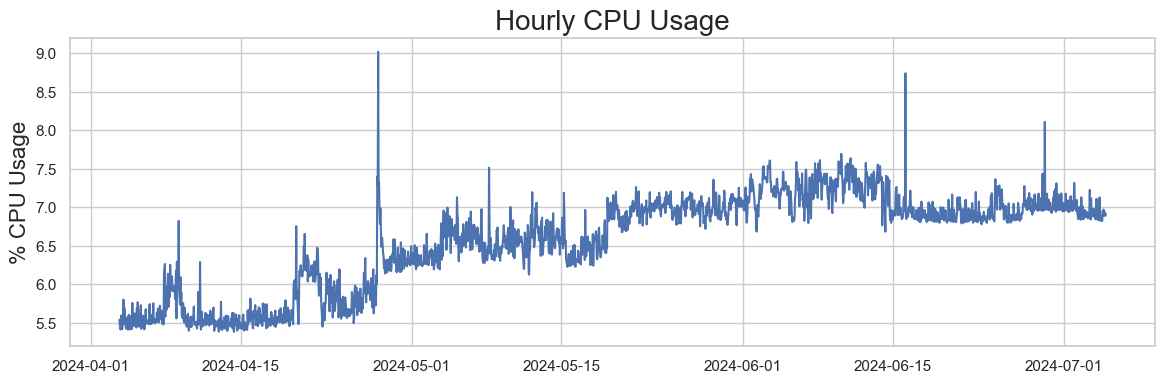

In [5]:
#plot
plt.figure(figsize=(14,4))
plt.plot(df)
plt.title('Hourly CPU Usage', fontsize=20)
plt.ylabel('% CPU Usage', fontsize=16)

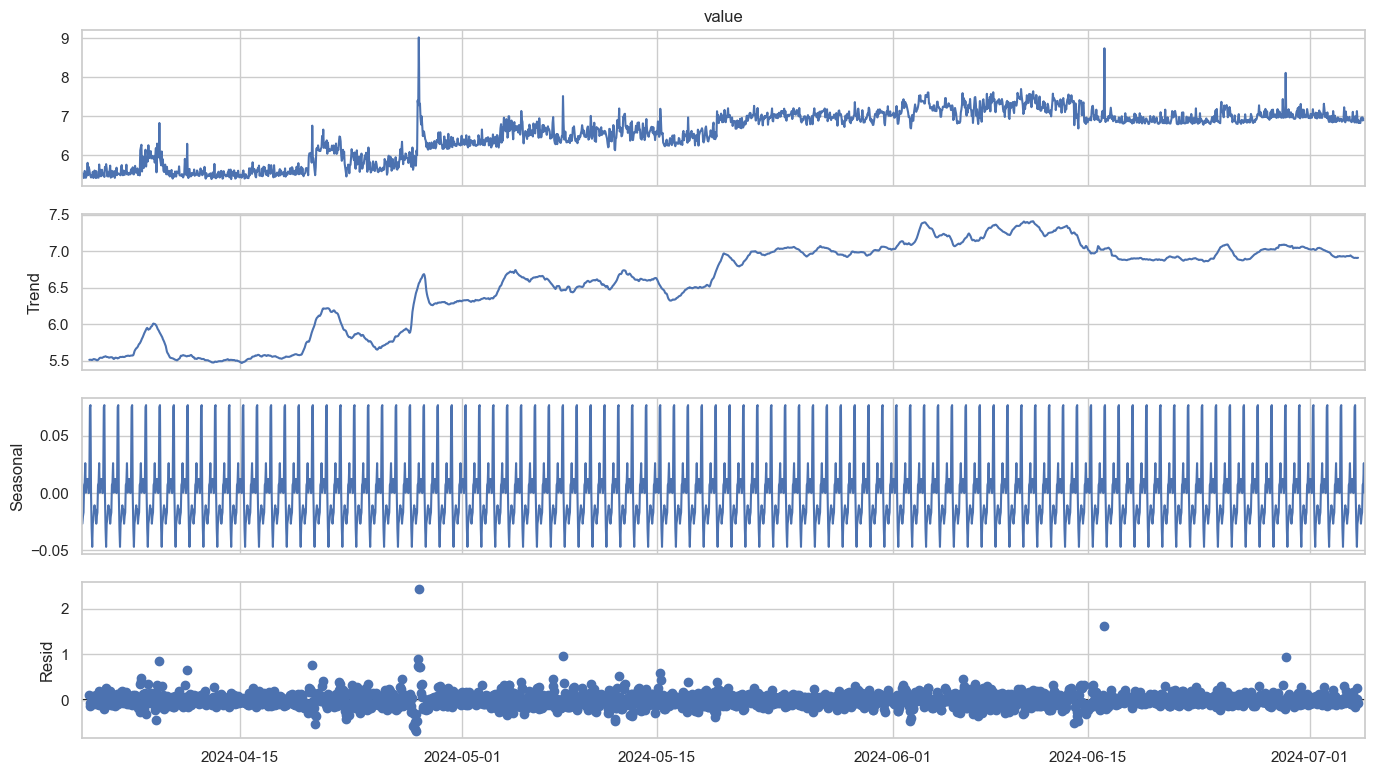

In [6]:
#STL (Seasonal Trend) Decomposition
plt.rc('figure',figsize=(14,8))
plt.rc('font',size=15)

result_stl = seasonal_decompose(df,model='additive')
fig = result_stl.plot()

In [7]:
dt_df = df.values - result_stl.trend
dt_df.dropna(inplace = True)

Text(0.5, 1.0, 'CPU Usage detrended by subtracting the trend component')

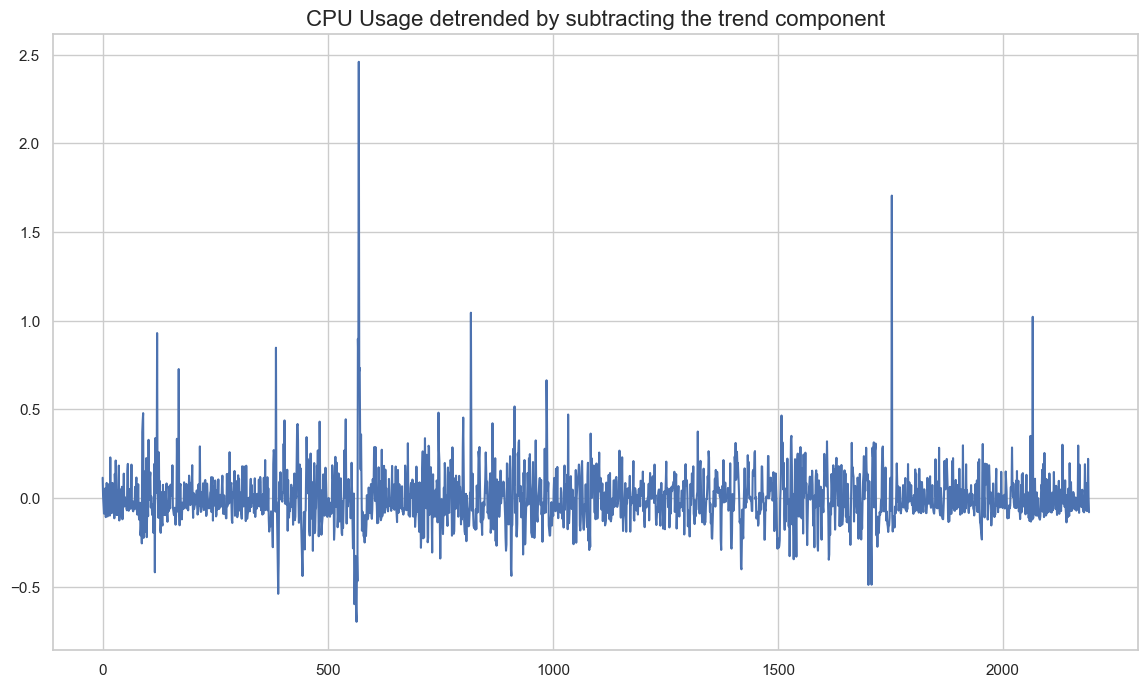

In [8]:
plt.plot(dt_df.values)
plt.title('CPU Usage detrended by subtracting the trend component', fontsize=16)

In [9]:
# let's check for the stationaity in the series using Augmented Dickey Fuller
# ADF Test
result = adfuller(df, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -1.9111102887584013
p-value: 0.3268526667670141


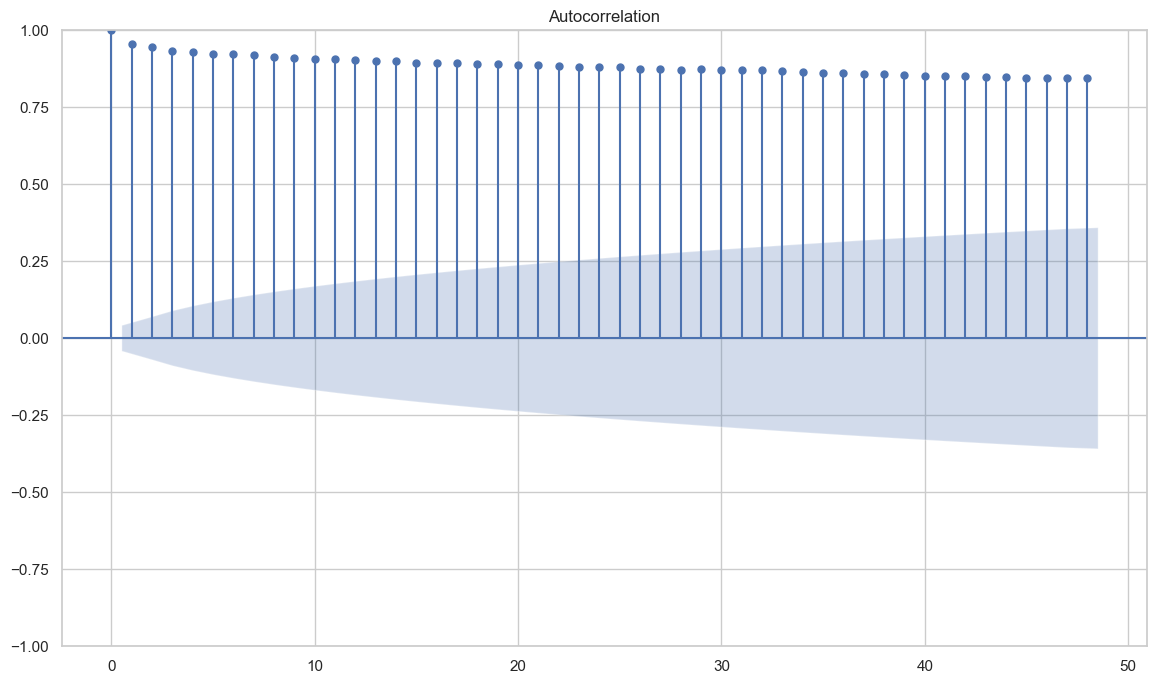

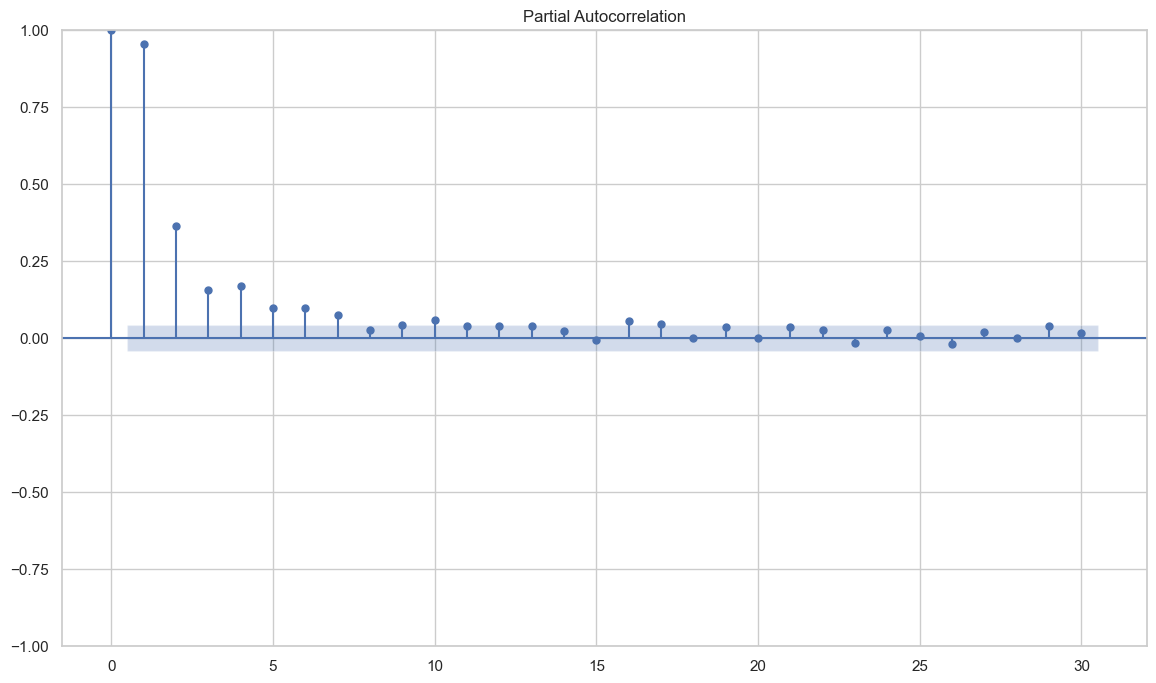

In [10]:
# Let’s look at ACF and PACF plots to get an idea for p and q values
plot_acf(df, lags=48);
plot_pacf(df, lags=30);

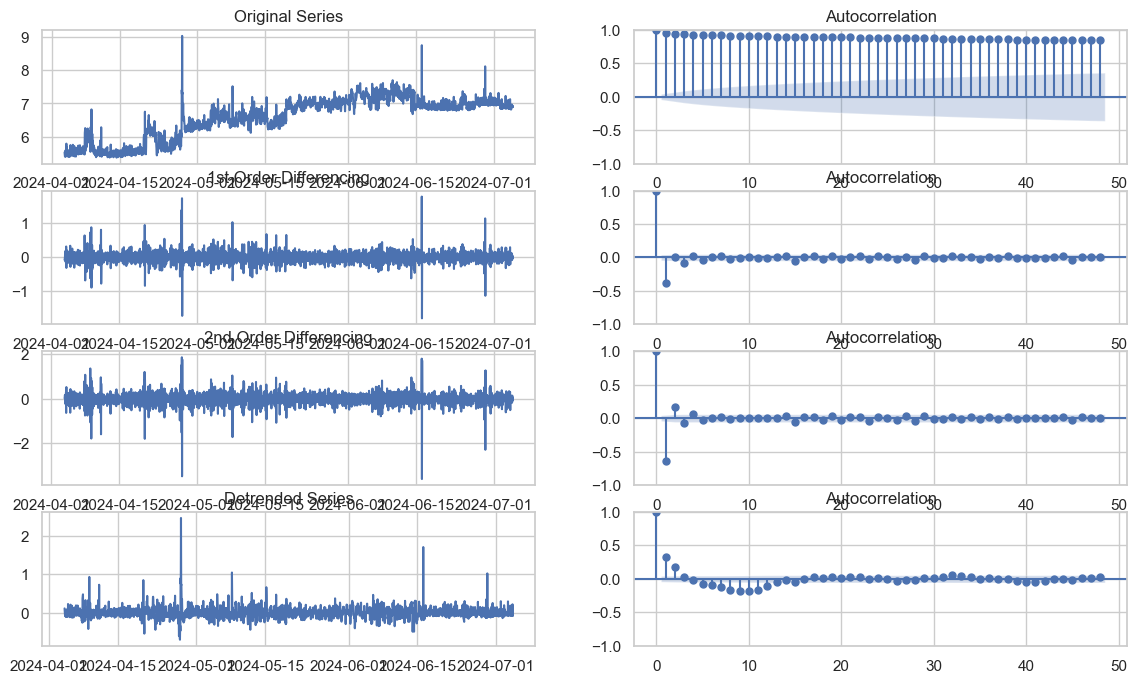

In [11]:
# Original Series
fig, axes = plt.subplots(4, 2)
axes[0, 0].plot(df); axes[0, 0].set_title('Original Series')
plot_acf(df, lags = 48, ax=axes[0, 1])

# 1st Differencing
df_1diff = df.diff()
df_1diff.dropna(inplace=True)
axes[1, 0].plot(df_1diff); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df_1diff, lags = 48, ax=axes[1, 1])

# 2nd Differencing
df_2diff = df.diff().diff()
df_2diff.dropna(inplace=True)
axes[2, 0].plot(df_2diff); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df_2diff, lags = 48, ax=axes[2, 1])

# Detrended Series
axes[3, 0].plot(dt_df); axes[3, 0].set_title('Detrended Series')
plot_acf(dt_df, lags = 48, ax=axes[3, 1])

plt.show()

In [12]:
# ADF Test
result = adfuller(df_1diff, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -14.857359508015456
p-value: 1.740163298493059e-27
Critial Values:
   1%, -3.43333403252856
Critial Values:
   5%, -2.862858248918234
Critial Values:
   10%, -2.5674717686007003


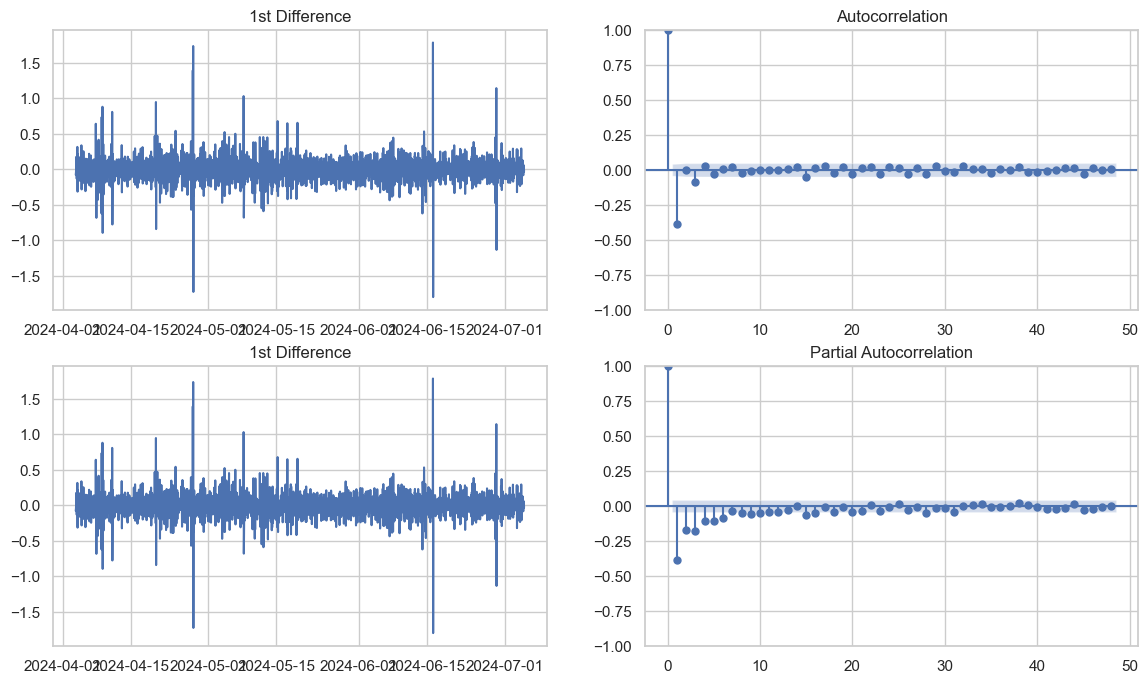

In [60]:
# Original Series
fig, axes = plt.subplots(2, 2)
axes[0, 0].plot(df_1diff); axes[0, 0].set_title('1st Difference')
plot_acf(df_1diff, lags = 48, ax=axes[0, 1])

axes[1, 0].plot(df_1diff); axes[1, 0].set_title('1st Difference')
plot_pacf(df_1diff, lags = 48, ax=axes[1, 1])

plt.show()

In [61]:
model = auto_arima(df, start_p=0, start_q=0,
                          max_p=3, max_q=1,m=7,start_P=0,start_Q=0, 
                          max_P =3, max_Q =1,
                          seasonal=True,
                          d=1,D=1,trace=True,
                          error_action='ignore',   
                          suppress_warnings=True,  
                          stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=239.315, Time=0.11 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-722.233, Time=0.65 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=3.28 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=-117.264, Time=0.26 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=-981.489, Time=3.14 sec
 ARIMA(1,1,0)(3,1,0)[7]             : AIC=-1088.897, Time=3.93 sec
 ARIMA(1,1,0)(3,1,1)[7]             : AIC=inf, Time=12.91 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=5.15 sec
 ARIMA(0,1,0)(3,1,0)[7]             : AIC=-736.515, Time=1.23 sec
 ARIMA(2,1,0)(3,1,0)[7]             : AIC=-1146.263, Time=3.10 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=-1039.018, Time=1.53 sec
 ARIMA(2,1,0)(3,1,1)[7]             : AIC=inf, Time=13.07 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=inf, Time=4.82 sec
 ARIMA(3,1,0)(3,1,0)[7]             : AIC=-1213.672, Time=3.47 sec
 ARIMA(3,1,0)(2,1,0)[7]             : AIC=-1111.308, 

In [62]:
sarima = SARIMAX(df,
                order=(3,1,0),
                seasonal_order=(3,1,0,7))
predictions = sarima.fit().predict()

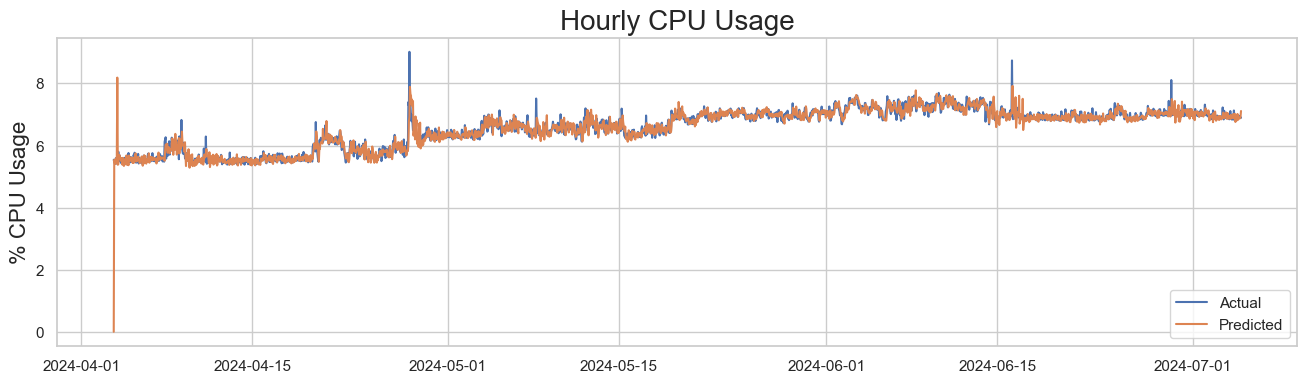

In [63]:
plt.figure(figsize=(16,4))
plt.plot(df, label="Actual")
plt.plot(predictions, label="Predicted")
plt.title('Hourly CPU Usage', fontsize=20)
plt.ylabel('% CPU Usage', fontsize=16)
plt.legend()

In [64]:
train = df[:2196]
test = df[2196:]

In [68]:
sr_model = SARIMAX(train,
                order=(3,1,0),
                seasonal_order=(3,1,0,7))
sr_fit = sr_model.fit()
sr_fc = sr_fit.forecast(steps=20)

In [69]:
sr_rmse = np.sqrt(mean_squared_error(test,sr_fc))
print("SARIMAX RMSE -> {}".format(sr_rmse))

SARIMAX RMSE -> 0.09418411301681495


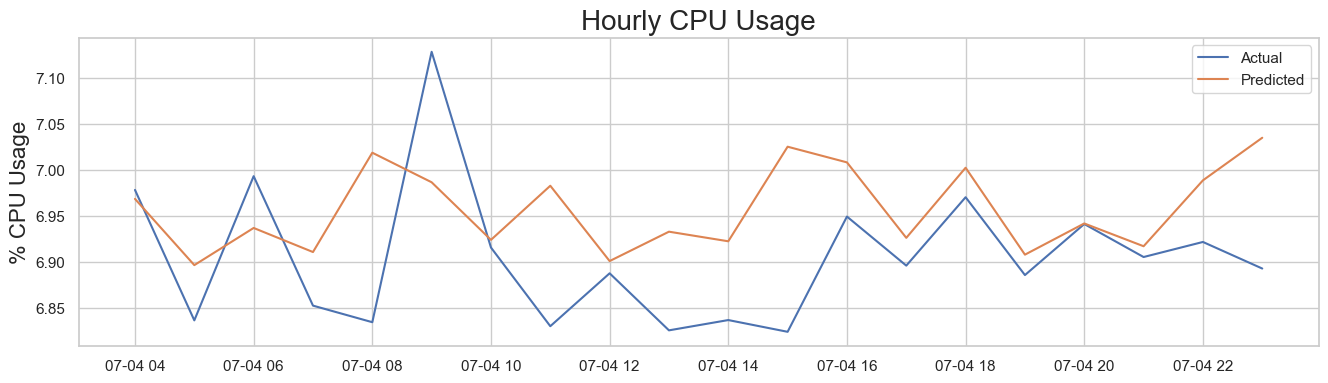

In [70]:
plt.figure(figsize=(16,4))
plt.plot(test, label="Actual")
plt.plot(sr_fc, label="Predicted")
plt.title('Hourly CPU Usage', fontsize=20)
plt.ylabel('% CPU Usage', fontsize=16)
plt.legend()